In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point, Polygon
import numpy as np

In [2]:
ward = gpd.read_file('statistical-gis-boundaries-london/ESRI/London_Ward.shp')
ward = ward.to_crs(epsg=4326)
ward.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,LB_GSS_CD,BOROUGH,POLY_ID,geometry
0,Chessington South,E05000405,755.173,0.0,E09000021,Kingston upon Thames,50840,"POLYGON ((-0.33068 51.32901, -0.33059 51.32909..."
1,Tolworth and Hook Rise,E05000414,259.464,0.0,E09000021,Kingston upon Thames,117160,"POLYGON ((-0.30846 51.37586, -0.30834 51.37606..."
2,Berrylands,E05000401,145.390,0.0,E09000021,Kingston upon Thames,50449,"POLYGON ((-0.30385 51.39249, -0.30375 51.39252..."
3,Alexandra,E05000400,268.506,0.0,E09000021,Kingston upon Thames,50456,"POLYGON ((-0.26990 51.38845, -0.26975 51.38838..."
4,Beverley,E05000402,187.821,0.0,E09000021,Kingston upon Thames,117161,"POLYGON ((-0.24662 51.39921, -0.24672 51.39921..."


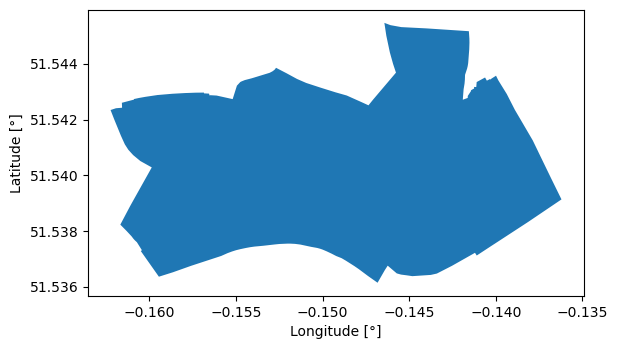

In [3]:
poly = ward[ward.NAME == 'Camden Town with Primrose Hill'].geometry
poly.plot()
plt.xlabel('Longitude [°]')
plt.ylabel('Latitude [°]');

In [4]:
station = pd.read_csv('station.csv')
station.head()

,id,installed,latitude,locked,longitude,name,bikes_count,docks_count,nbEmptyDocks,temporary,terminal_name,install_date,removal_date
0,92,True,51.498898,False,-0.100441,"Borough Road, Elephant & Castle",40,41,0,False,1082,2010-07-13,NaN
1,669,True,51.476149,False,-0.123258,"Teversham Lane, Stockwell",39,39,0,False,300036,2013-10-30,NaN
2,390,True,51.521776,False,-0.068856,"Buxton Street 1, Shoreditch",39,41,1,False,1223,2011-02-15,NaN
3,749,True,51.539329,False,-0.074285,"Haggerston Road, Haggerston",36,37,1,False,300081,2013-12-04,NaN
4,496,True,51.525120,False,-0.015578,"Devons Road, Bow",37,39,2,False,200255,2012-01-24,NaN


In [5]:
# Checking for possible dirty data
print('Duplicated rows:', station.duplicated().sum())
print('Not installed:', (~station.installed).sum())
print('Locked:', station.locked.sum())
print('Temporary:', station.temporary.sum())
print('Removed:', station.removal_date.notna().sum())

Duplicated rows: 0
Not installed: 0
Locked: 0
Temporary: 5
Removed: 3


In [6]:
print('Min ID:', station.id.min())
print('Max ID:', station.id.max())

print('Number of stations:', station.shape[0])

Min ID: 1
Max ID: 857
Number of stations: 799


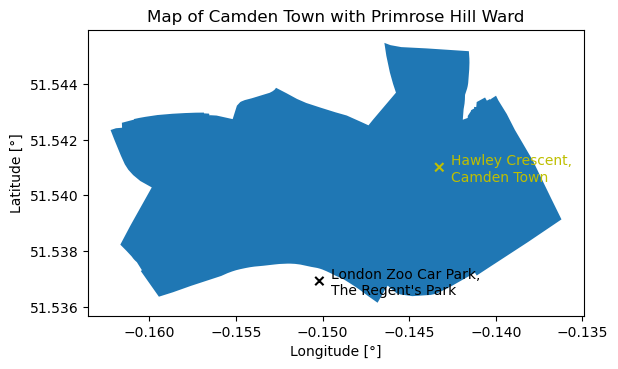

In [7]:
station_1 = station[station.name == 'Hawley Crescent, Camden Town']
station_2 = station[station.name == 'London Zoo Car Park, The Regent\'s Park']

p1 = Point(station_1.longitude, station_1.latitude)
p2 = Point(station_2.longitude, station_2.latitude)

fig, ax = plt.subplots()
poly.plot(ax=ax)
ax.scatter([p1.x, p2.x], [p1.y, p2.y], c=['y', 'k'], marker='x')
ax.set_title('Map of Camden Town with Primrose Hill Ward')
ax.set_xlabel('Longitude [°]')
ax.set_ylabel('Latitude [°]');

ax.annotate('Hawley Crescent,\nCamden Town', (p1.x + 7e-4, p1.y - 5e-4), c='y')
ax.annotate('London Zoo Car Park,\nThe Regent\'s Park', (p2.x + 7e-4, p2.y - 5e-4));

In [8]:
# Checking if the Points (Hawley Crescent and London Zoo Car Park stations) are within the Polygon (Camden Town ward) using the Point.within method
print('Is Hawley Crescent inside Camden Town?', p1.within(poly).iloc[0])
print('Is London Zoo Car Park inside Camden Town?', p2.within(poly).iloc[0])


Is Hawley Crescent inside Camden Town? True
Is London Zoo Car Park inside Camden Town? False


In [9]:
station['coordinate'] = list(map(Point, station.longitude, station.latitude))
station.head()

,id,installed,latitude,locked,longitude,name,bikes_count,docks_count,nbEmptyDocks,temporary,terminal_name,install_date,removal_date,coordinate
0,92,True,51.498898,False,-0.100441,"Borough Road, Elephant & Castle",40,41,0,False,1082,2010-07-13,NaN,POINT (-0.100440521 51.49889832)
1,669,True,51.476149,False,-0.123258,"Teversham Lane, Stockwell",39,39,0,False,300036,2013-10-30,NaN,POINT (-0.1232585 51.47614939)
2,390,True,51.521776,False,-0.068856,"Buxton Street 1, Shoreditch",39,41,1,False,1223,2011-02-15,NaN,POINT (-0.068856 51.521776)
3,749,True,51.539329,False,-0.074285,"Haggerston Road, Haggerston",36,37,1,False,300081,2013-12-04,NaN,POINT (-0.07428467499999999 51.53932857)
4,496,True,51.525120,False,-0.015578,"Devons Road, Bow",37,39,2,False,200255,2012-01-24,NaN,POINT (-0.015578 51.52512)


In [10]:
station['ward'] = np.nan
station['borough'] = np.nan

for i in range(len(station)):
    for j in range(len(ward)):
        if station.loc[i, 'coordinate'].within(ward.loc[j, 'geometry']):
            station.loc[i, 'ward'] = ward.loc[j, 'NAME']
            station.loc[i, 'borough'] = ward.loc[j, 'BOROUGH']

# Checking there are no empty values
print(station.ward.isna().sum())
print(station.borough.isna().sum())
station.head()
        

0
0


,id,installed,latitude,locked,longitude,name,bikes_count,docks_count,nbEmptyDocks,temporary,terminal_name,install_date,removal_date,coordinate,ward,borough
0,92,True,51.498898,False,-0.100441,"Borough Road, Elephant & Castle",40,41,0,False,1082,2010-07-13,NaN,POINT (-0.100440521 51.49889832),Cathedrals,Southwark
1,669,True,51.476149,False,-0.123258,"Teversham Lane, Stockwell",39,39,0,False,300036,2013-10-30,NaN,POINT (-0.1232585 51.47614939),Stockwell,Lambeth
2,390,True,51.521776,False,-0.068856,"Buxton Street 1, Shoreditch",39,41,1,False,1223,2011-02-15,NaN,POINT (-0.068856 51.521776),Spitalfields and Banglatown,Tower Hamlets
3,749,True,51.539329,False,-0.074285,"Haggerston Road, Haggerston",36,37,1,False,300081,2013-12-04,NaN,POINT (-0.07428467499999999 51.53932857),Queensbridge,Hackney
4,496,True,51.525120,False,-0.015578,"Devons Road, Bow",37,39,2,False,200255,2012-01-24,NaN,POINT (-0.015578 51.52512),Bromley-by-Bow,Tower Hamlets


In [11]:
pd.concat([station[station.name == 'Hawley Crescent, Camden Town'], station[station.name == ('London Zoo Car Park, The Regent\'s Park')]])

,id,installed,latitude,locked,longitude,name,bikes_count,docks_count,nbEmptyDocks,temporary,terminal_name,install_date,removal_date,coordinate,ward,borough
608,713,True,51.541007,False,-0.143261,"Hawley Crescent, Camden Town",20,22,2,False,200122,2013-11-18,NaN,POINT (-0.14326094 51.54100708),Camden Town with Primrose Hill,Camden
723,343,True,51.536922,False,-0.150181,"London Zoo Car Park, The Regent's Park",25,36,11,False,1188,2010-07-27,NaN,POINT (-0.150181444 51.53692216),Regent's Park,Camden


In [12]:
station[['name', 'ward', 'borough', 'latitude', 'longitude']].to_csv('station_w_ward.csv', index=False)